# Re-estimation of a transition matrix

In [33]:
import numpy as np
import scipy
import pyemma
import matplotlib.pyplot as plt

## Generate discrete trajectory from transition matrix

In [34]:
import random
import numpy as np

size = 100000

T = np.matrix([[ 0.97, 0.03, 0],[0.015 , 0.97, 0.015],[ 0, 0.03, 0.97]])
#print(T)

def state0(i,num):
    if num>T[0,0]:
        return i+1
    return i

def state1(i,num):
    if num<T[1,0]:
        return i-1
    elif T[1,0]<num<(T[1,2]+T[1,0]):
        return i+1
    return i

def state2(i,num):
    if num>T[2,2]:
        return i-1
    return i

def decider(i, num):
    new_i = i
    if i==0:
        new_i = state0(i,num)
    if i==1:
        new_i = state1(i,num)
    if i==2:
        new_i = state2(i,num)

    return new_i


i=0 # initial condition
k=0

dtraj=[]
while k<size:
    num = random.uniform(0, 1)
    i = decider(i, num)
    dtraj.append(i)
    k=k+1


## Generate continuous trajectory from discrete trajectory

In [44]:
# parameters

mu_0 = [0,0]
mu_1 = [-1.5,1.5]
mu_2 = [-1.5,-1.5]

sigma_0 = [[1,0],[0,1]]
sigma_1 = [[1,0],[0,1]]
sigma_2 = [[1,0],[0,1]]

mus = [mu_0, mu_1, mu_2]
sigmas = [sigma_0, sigma_1, sigma_2]

# generates a continuous trajectory drawn from bivariate gaussians
def generate_traj(dtraj, mus, sigmas):
    traj = []
    for i in range(len(dtraj)):
        if dtraj[i] == 0:
            traj.append(np.random.multivariate_normal(mus[0], sigmas[0], size=1)[0])
        elif dtraj[i] == 1:
            traj.append(np.random.multivariate_normal(mus[1], sigmas[1], size=1)[0])
        elif dtraj[i] == 2:
            traj.append(np.random.multivariate_normal(mus[2], sigmas[2], size=1)[0])
        else:
            print("something went wrong")
            exit()
    return np.array(traj)

traj = generate_traj(dtraj, mus, sigmas)

#print(traj)

## Rotate trajectory into 5 dimensions and add noise

In [45]:
def random_matrix():
    v=np.array([np.random.random() for n in range(5)])
    w=np.array([np.random.random() for n in range(5)])
    # generating two random 5d vectors
    vn=v/np.sqrt(sum(v**2))
    wn=(w-np.dot(w,vn)*vn)/np.sqrt(sum((w-np.dot(w,vn)*vn)**2))
    # orthonormalization with Gram-Schmidt
    
    return np.array([vn,wn])

def fived(x,y, random_matrix, noise):
    noise_matrix=[[np.random.random() - 0.5 for n in range(5)],[np.random.normal() for n in range(5)],[np.random.poisson() for n in range(5)]]
    out=np.matmul(np.array([x,y]), random_matrix) + np.array(noise_matrix[noise])
    return out

random_matrix = random_matrix()

In [46]:
traj_5dim = []

for i in range(len(traj)):
    traj_5dim.append(fived(traj[i,0],traj[i,1], random_matrix, 0))

traj_5dim = np.array(traj_5dim)

## Analyse generated trajectory with pyEMMA

In [47]:
#specify data
data = traj_5dim

tica = pyemma.coordinates.tica(data, lag=10, var_cutoff=0.95)
tica_concatenated = np.concatenate(tica.get_output())

cls_tica = pyemma.coordinates.cluster_kmeans(tica, k=3, max_iter=50, stride=10)
its_tica = pyemma.msm.its(cls_tica.dtrajs, lags=[1, 2, 5, 10, 20], nits=2, errors='bayes')

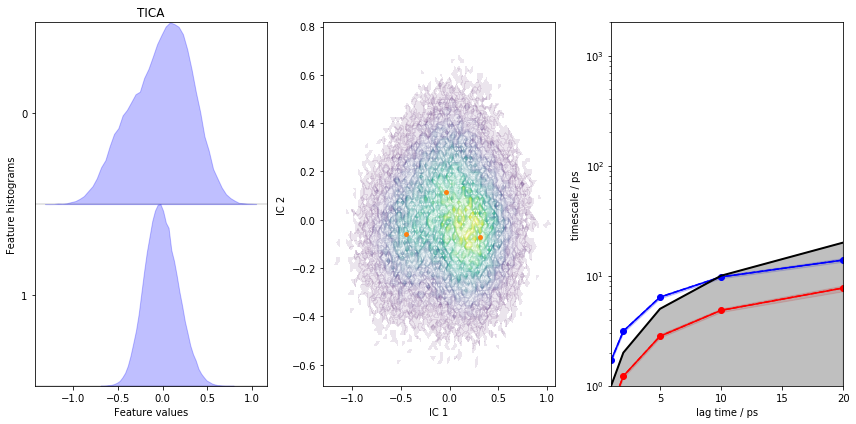

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
pyemma.plots.plot_feature_histograms(tica_concatenated, ax=axes[0])
axes[0].set_title('TICA')
pyemma.plots.plot_density(*tica_concatenated.T, ax=axes[1], cbar=False, alpha=0.1)

axes[1].scatter(*cls_tica.clustercenters.T, s=15, c='C1')
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
pyemma.plots.plot_implied_timescales(its_tica, ax=axes[2], units='ps')
axes[2].set_ylim(1, 2000)
axes[2].set_ylim(1, 2000)
fig.tight_layout()

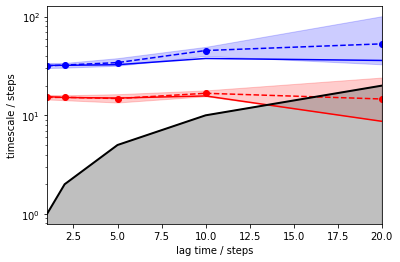

In [49]:
its_hmm = pyemma.msm.timescales_hmsm(cls_tica.dtrajs, nstates=3, lags=[1, 2, 5, 10, 20], errors='bayes')
pyemma.plots.plot_implied_timescales(its_hmm, ylog=True)

(<Figure size 648x648 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f434e8aef50>,
       dtype=object))

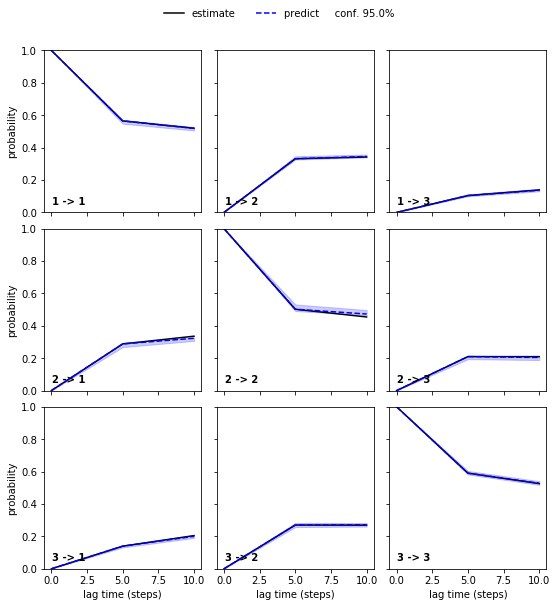

In [65]:
# generate hmsm
bayesian_hmm = pyemma.msm.bayesian_hidden_markov_model(cls_tica.dtrajs, nstates=3, lag=5)
pyemma.plots.plot_cktest(bayesian_hmm.cktest(3))

In [66]:
# transition matrix
T = scipy.linalg.fractional_matrix_power(bayesian_hmm.transition_matrix, 1/5)
print(bayesian_hmm.transition_matrix)
print()
print(T)

[[0.85192384 0.08254831 0.06552785]
 [0.14411363 0.85105784 0.00482853]
 [0.12390084 0.00522957 0.87086959]]

[[9.66313208e-01 1.88641433e-02 1.48226490e-02]
 [3.29332000e-02 9.66978018e-01 8.87820086e-05]
 [2.80268428e-02 9.61560192e-05 9.71877001e-01]]


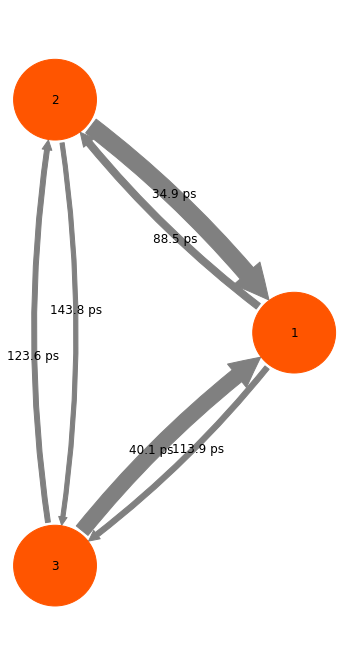

In [67]:
nstates = 3

mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = bayesian_hmm.mfpt(bayesian_hmm.metastable_sets[i], bayesian_hmm.metastable_sets[j])

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

pyemma.plots.plot_network(
    inverse_mfpt,
    pos=np.asarray([[0, 0], [-1.5, 1.5], [-1.5, -1.5]]),
    arrow_label_format='%.1f ps',
    arrow_labels=mfpt,
    arrow_scale=3.0,
    state_labels=range(1, nstates + 1),
    size=12)